In [1]:
import warnings
warnings.filterwarnings('ignore')
import os
os.environ['PROJ_LIB'] = r'C:/Users/mastr/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Windows OS
# os.environ['PROJ_LIB'] = r'/Users/mmastro/miniconda3/pkgs/proj4-5.2.0-ha925a31_1/Library/share'     ## Mac OS
import glob
import netCDF4 as nc
import numpy as np
import pandas as pd
import xarray as xr
#from scipy.signal import argrelextrema                      # Find local Maxima-Minima in numpy array
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cartopy.feature as cfeature
import cartopy as cart
import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker

Functions declaration

In [80]:
def detrend_dim(da, dim, degree):
    # Store original attributes
    original_attrs = da.attrs

    # Detrend along a single dimension
    p = da.polyfit(dim=dim, deg=degree)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    da_det = da - fit
    
    # Restore original attributes
    da_det.attrs = original_attrs
    
    return da_det

def xr_mean_list(xarray_list):
    # Step 1: Group the xarray objects by their "esm" attribute
    esm_groups = {}
    for xr_obj in xarray_list:
        esm_value = xr_obj.attrs.get('esm', None)
        if esm_value not in esm_groups:
            esm_groups[esm_value] = []
        esm_groups[esm_value].append(xr_obj)

    # Step 2: Sort the esm groups alphabetically by their esm value
    sorted_esm_values = sorted(esm_groups.keys())

    # Step 3: Calculate the mean for each group in alphabetical order
    mean_results = {}
    for esm_value in sorted_esm_values:
        xr_objs = esm_groups[esm_value]
        
        # Concatenate all xarray objects in this group along a new dimension (e.g., 'stacked_xarrays')
        combined = xr.concat(xr_objs, dim='stacked_xarrays')
        
        # Calculate the mean along the 'stacked_xarrays' dimension
        mean_results[esm_value] = combined.mean(dim='stacked_xarrays')
    
    return mean_results


## Fuction for subsetting colormap values ## 
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

## Function for creating a path, if needed ##
def checkDir(out_path):
    if not os.path.exists(out_path):
        os.makedirs(out_path)

import numpy as np
import xarray as xr
from scipy.stats import t

def lag_linregress_3D(x, y, lagx=0, lagy=0):
    """
    Input: Two xr.DataArrays of any dimensions with the first dim being time. 
    Thus the input data could be a 1D time series, or for example, have three dimensions (time,lat,lon). 
    Datasets can be provided in any order, but note that the regression slope and intercept will be calculated
    for y with respect to x.
    Output: Covariance, correlation, regression slope and intercept, p-value, standard error on regression,
    and R-squared between the two datasets along their aligned time dimension.  
    Lag values can be assigned to either of the data, with lagx shifting x, and lagy shifting y, with the specified lag amount. 
    """ 
    # 1. Ensure that the data are properly aligned to each other. 
    x, y = xr.align(x, y)
    
    # 2. Add lag information if any, and shift the data accordingly
    if lagx != 0:
        x = x.shift(time=-lagx).dropna(dim='time')
        x, y = xr.align(x, y)

    if lagy != 0:
        y = y.shift(time=-lagy).dropna(dim='time')
        x, y = xr.align(x, y)
 
    # 3. Compute data length, mean and standard deviation along time axis for further use
    n = x.shape[0]
    xmean = x.mean(axis=0)
    ymean = y.mean(axis=0)
    xstd = x.std(axis=0)
    ystd = y.std(axis=0)
    
    # 4. Compute covariance along time axis
    cov = np.sum((x - xmean) * (y - ymean), axis=0) / n
    
    # 5. Compute correlation along time axis
    cor = cov / (xstd * ystd)
    
    # 6. Compute regression slope and intercept
    slope = cov / (xstd ** 2)
    intercept = ymean - xmean * slope
    y_pred = intercept + slope * x
    res = y - y_pred

    # 7. Compute P-value and standard error
    # Compute t-statistics
    tstats = cor * np.sqrt(n-2) / np.sqrt(1 - cor**2)
    stderr = slope / tstats
    
    pval = t.sf(tstats, n-2) * 2
    pval = xr.DataArray(pval, dims=cor.dims, coords=cor.coords)

    # 8. Compute R-squared
    sst = np.sum((y - ymean) ** 2, axis=0)
    ssr = np.sum(res ** 2, axis=0)
    r_squared = 1 - ssr / sst

    r_squared = xr.DataArray(r_squared, dims=cor.dims, coords=cor.coords)

    return slope, cor, intercept, pval, stderr, r_squared, y_pred


def xr_multipletest(p, alpha=0.05, method='fdr_bh', **multipletests_kwargs):
    """Apply statsmodels.stats.multitest.multipletests for multi-dimensional xr.objects."""
    from statsmodels.stats.multitest import multipletests
    # stack all to 1d array
    p_stacked = p.stack(s=p.dims)
    # mask only where not nan: https://github.com/statsmodels/statsmodels/issues/2899
    mask = np.isfinite(p_stacked)
    pvals_corrected = np.full(p_stacked.shape, np.nan)
    reject = np.full(p_stacked.shape, np.nan)
    # apply test where mask
    reject[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[0]
    pvals_corrected[mask] = multipletests(
        p_stacked[mask], alpha=alpha, method=method, **multipletests_kwargs)[1]

    def unstack(reject, p_stacked):
        """Exchange values from p_stacked with reject (1d array) and unstack."""
        xreject = p_stacked.copy()
        xreject.values = reject
        xreject = xreject.unstack()
        return xreject

    reject = unstack(reject, p_stacked)
    pvals_corrected = unstack(pvals_corrected, p_stacked)
    return reject, pvals_corrected


In [3]:
# Zonal mean of REAN and ESM

import json
import os
import glob
import geopandas as gpd
from importlib.machinery import SourceFileLoader
# imports the module from the given path
gpd = SourceFileLoader("geopandas","C:/Users/mastr/miniconda3/pkgs/geopandas-0.7.0-py_1/site-packages/geopandas/__init__.py").load_module()
import regionmask

def cell_weight(ds):
    R = 6.371e6
    dϕ = np.deg2rad(ds.lat[1] - ds.lat[0])
    dλ = np.deg2rad(ds.lon[1] - ds.lon[0])
    dlat = R * dϕ * xr.ones_like(ds.lon)
    dlon = R * dλ * np.cos(np.deg2rad(ds.lat))
    cell_area = dlon * dlat
    return(cell_area)

def mask_shape(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    ds_m = ds.where(mask)
    return ds_m

def zonal_stat(ds,gdf):
    # Create mask of multiple regions from shapefile
    mask = regionmask.mask_3D_geopandas(
            gdf,
            ds.lon,
            ds.lat,
            drop=True
        )
    # Apply mask to xarray
    ds_m = ds.where(mask)
    # Calculate cell area of the xarray
    cell_area = cell_weight(ds)
    # Zonal statistic for all the regions
    ds_z = ds_m.weighted(cell_area).mean(["lat","lon"])
    # ds_z = ds_z.groupby("region").mean(])
    return ds_z

# geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/amazon_border/biome.shp')))
geodf = gpd.read_file((os.path.join('C:/Users/mastr/Documents/Amazon/hybas_sa_lev01-12_v1c/hybas_sa_lev02_v1c.shp')))

In [4]:
# -- Path for the output files (images, etc)
# out_path = 'C:/Users/mastr/Documents/Amazon/RESULTS/'
out_path = 'G:/Shared drives/Amazon_ENSO_work/RESULTS/MLR/'

# -- Create directories
checkDir(out_path)

### Open 1pctCO2-rad data

NEP

In [5]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'nep'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nep = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nep.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_nep):
    ds_nep[i] = ds_nep[i].isel(time = slice(0,1680))
    ds_nep[i] = ds_nep[i].assign_attrs(esm=files_list[i].source_id)
    ds_nep[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_nep[i] = ds_nep[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_nep[i] = ds_nep[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nep[i] = ds_nep[i].where(ds_nep[i] != -3.7270379e-07)


NBP

In [158]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'nbp'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_nbp = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_nbp.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_nbp):
    ds_nbp[i] = ds_nbp[i].isel(time = slice(0,1680))
    ds_nbp[i] = ds_nbp[i].assign_attrs(esm=files_list[i].source_id)
    ds_nbp[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_nbp[i] = ds_nbp[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_nbp[i] = ds_nbp[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_nbp[i] = ds_nbp[i].where(ds_nbp[i] != -3.7270379e-07)


Temperature

In [6]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'tas'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_tas = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_tas.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_tas):
    ds_tas[i] = ds_tas[i].isel(time = slice(0,1680))
    ds_tas[i] = ds_tas[i].assign_attrs(esm=files_list[i].source_id)
    ds_tas[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_tas[i] = ds_tas[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_tas[i] = ds_tas[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_tas[i] = ds_tas[i].where(ds_tas[i] != -3.7270379e-07)


Precipitation

In [63]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'pr'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_pr = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_pr.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_pr):
    ds_pr[i] = ds_pr[i].isel(time = slice(0,1680))
    ds_pr[i] = ds_pr[i].assign_attrs(esm=files_list[i].source_id)
    ds_pr[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_pr[i] = ds_pr[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_pr[i] = ds_pr[i].resample(time="Y", label='right').sum()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_pr[i] = ds_pr[i].where(ds_pr[i] != -3.7270379e-07)


Soil Moisture

In [8]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'mrso'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_mrso = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_mrso.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_mrso):
    ds_mrso[i] = ds_mrso[i].isel(time = slice(0,1680))
    ds_mrso[i] = ds_mrso[i].assign_attrs(esm=files_list[i].source_id)
    ds_mrso[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_mrso[i] = ds_mrso[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_mrso[i] = ds_mrso[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_mrso[i] = ds_mrso[i].where(ds_mrso[i] != -3.7270379e-07)


Shortwave Incoming Radiation

In [9]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'rsds'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_rsds = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_rsds.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_rsds):
    ds_rsds[i] = ds_rsds[i].isel(time = slice(0,1680))
    ds_rsds[i] = ds_rsds[i].assign_attrs(esm=files_list[i].source_id)
    ds_rsds[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_rsds[i] = ds_rsds[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_rsds[i] = ds_rsds[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_rsds[i] = ds_rsds[i].where(ds_rsds[i] != -3.7270379e-07)


Relative humidity

In [20]:
data_path = 'F:/Data/analysis/'

scenario = '1pctCO2-rad'
var_name = 'hurs'
files = var_name + '_*_' + scenario + '.nc' 

files_list = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):               # List of files sorted by name
        content = nc.Dataset(filepath)
        files_list.append(content)                                              # to retrieve netcdf original ATTRIBUT
        
ds_hurs = []
for filepath in sorted(glob.glob(os.path.join(data_path+'/'+scenario+'/'+files))):                                       ## List of files sorted by name
    content = xr.open_dataarray(filepath, drop_variables=["time_bnds","lon_bnds","lat_bnds"])          #, chunks = {"time" : 720}
    ds_hurs.append(content)

# Retain from year 1850 to 1989
# Uniform calendar, assign esm name, subsetting latitude, resample from M to Y
for i, item in enumerate(ds_hurs):
    ds_hurs[i] = ds_hurs[i].isel(time = slice(0,1680))
    ds_hurs[i] = ds_hurs[i].assign_attrs(esm=files_list[i].source_id)
    ds_hurs[i]['time'] = pd.date_range(start = "1850", periods=1680, freq = "M")
    ds_hurs[i] = ds_hurs[i].sel(lat=slice(-30,30), lon= slice(260,340))
    ds_hurs[i] = ds_hurs[i].resample(time="Y", label='right').mean()

# CanESM5 hist and ssp have numerical values of ocean equal to 
# hist: -9.304011e-07
# ssp: -1.120609e-05

for i, item in enumerate(files_list):
    if files_list[i].source_id == "CanESM5":
        ds_hurs[i] = ds_hurs[i].where(ds_hurs[i] != -3.7270379e-07)


In [12]:
import math

def calculate_vpd(rh, tas, unit):
    """
    Input: Relative Humidity and Air Temperature 
    Output: Vapour Pressure Deficit (VPD), in kPa
    
    Parameters:
    rh : Relative Humidity in %
    tas : Air temperature in Kelvin or Celsius
    unit : 'Kelvin' or 'Celsius'
    """
    
    # Convert temperature to Celsius if given in Kelvin
    if unit == "Kelvin":
        tas_celsius = tas - 273.15
    elif unit == "Celsius":
        tas_celsius = tas
    else:
        raise ValueError("Insert correct Unit of Measure for Temperature: 'Kelvin' or 'Celsius'")
    
    # Calculate Saturation Vapour Pressure (SVP) in kPa
    svp = 0.61078 * np.exp((17.27 * tas_celsius) / (tas_celsius + 237.3))
    # Calculate Vapour Pressure Deficit (VPD) in kPa
    vpd = svp * (1 - rh / 100)
    vpd = vpd.assign_attrs(unit = "kPa")
    return vpd

In [13]:
ds_vpd = []
for i, item in enumerate(ds_hurs):
    content = calculate_vpd(ds_hurs[i], ds_tas[i], "Celsius")
    ds_vpd.append(content)

#### Define list of models and realizations

In [21]:
# Initialize lists for models and realizations
models = []
realiz = []

# Collect the models and realizations
for i, item in enumerate(files_list):
    models.append(item.source_id)
    realiz.append(item.variant_label)

# Zip the models and realiz lists together for sorting by source_id (models)
zipped = list(zip(models, realiz))

# Sort by the first element in each tuple (i.e., source_id)
zipped_sorted = sorted(zipped, key=lambda x: x[0])

# Unzip the sorted list back into separate lists for models and realiz
models_sorted, realiz_sorted = zip(*zipped_sorted)

# Convert them back to lists if needed
models_sorted = list(models_sorted)
realiz_sorted = list(realiz_sorted)

#### Correct lon-lat values 

In [160]:
# Correct the number of longitude points
ds_mrso = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_mrso, ds_nep)]
ds_tas = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_tas, ds_nep)]
ds_rsds = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_rsds, ds_nep)]
ds_pr = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_pr, ds_nep)]
ds_vpd = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_vpd, ds_nep)]
ds_nbp = [a.isel(lon = slice(0,b.lon.shape[0])) for a,b in zip(ds_nbp, ds_nep)]

# Assign the exactly same set of coordinates to ALL the dataarray (avoid duplication due to numerical approximation of lon lat)
ds_pr = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_pr,ds_nep)]
ds_tas = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_tas,ds_nep)]
ds_mrso = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_mrso,ds_nep)]
ds_rsds = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_rsds,ds_nep)]
ds_vpd = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_vpd,ds_nep)]
ds_nbp = [a.assign_coords(lat = b.lat, lon = b.lon) for a,b in zip(ds_nbp,ds_nep)]


Show correlation among predictors

<AxesSubplot: >

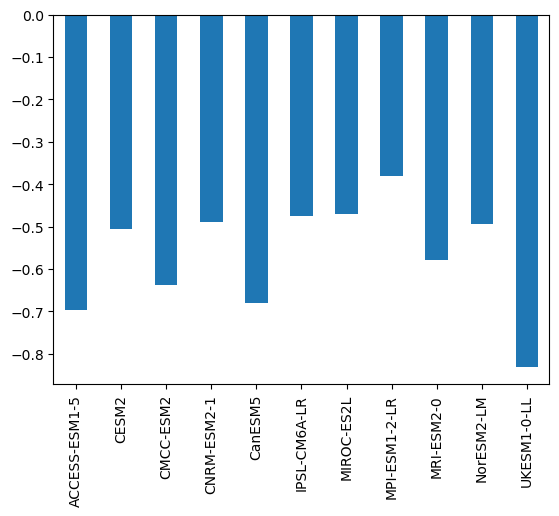

In [103]:
cor = []
for i,item in enumerate(ds_nep):
    content = zonal_stat(lag_linregress_3D(ds_mrso[i], ds_rsds[i])[1],geodf).sel(region = 1)
    cor.append(content.values)
cor = pd.DataFrame(cor)
cor = cor.rename(index=dict(zip(cor.index, models)))
cor.plot.bar(stacked = False, legend = False)

### Linear Regression of NEP and Climate

The relationship between NEP and CO2 is logarithimic, but if we consider the range of CO2 ppm of historical (280-400) and ssp585 (400-1135) separately, it is linear.\
For historical, the period is from 1850-01 to 1885-12 (36 yrs). \
For ssp585, the period is from 1886-01-01 to 1989-01-01 (104 yrs).

We calculate the long-term GAMMA carbon-climate feeback from the 1pctCO2-rad simulation as:

\begin{equation}
\Delta NEP_{\text{cum}} = a_{0} + sT * \Delta T + smrso * \Delta mrso + sSW_{in} * \Delta SW_{in} + sVPD * \Delta VPD + \epsilon
\end{equation}

We define $\Delta$ as the difference compared to the first year of the simulation. \
We multiply $sT$, $sPr$, $sSW_{in}$, $smrso$ and $sVPD$ by the number of years of the historical and ssp585 simulations obtaining $gCm^{-2}unit^{-1}$ 

#### Multivariate Gamma

In [39]:
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

def aic(n, mse, num_params):
    aic = n * np.log(mse) + 2 * num_params
    aic_c = aic + (2*num_params*(num_params+1))/(n - num_params - 1)
    return (aic, aic_c)

In [165]:
from sklearn import linear_model
from regressors import stats

# Define regression technique
# Ridge Regression with Cross-Validation
# alphas = np.linspace(.000001, 1)
# alphas = np.logspace(-6, 2, 10)
# ridge = linear_model.RidgeCV(alphas = alphas, cv =5)

# Ridge Regression without Cross-Validation
ridge = linear_model.Ridge()
# linreg = linear_model.LinearRegression()

coef_ridge_ssp = []
r2_ridge_ssp = []
pred_ridge_ssp = []
pval_ridge_ssp = []
for i, item in enumerate(ds_nep):

    # Define Delta wrt 1st year of simulation (of CO2atm in ssp585)
    x1 = ds_tas[i][36:] - ds_tas[i][36]
    x2 = ds_mrso[i][36:] - ds_mrso[i][36]
    x3 = ds_rsds[i][36:] - ds_rsds[i][36]
    x4 = ds_vpd[i][36:] - ds_vpd[i][36]
    x5 = ds_pr[i][36:] - ds_pr[i][36]

    y = ds_nbp[i].cumsum(dim = "time"); y = y[36:] - y[36]

    # Standardize predictors (mean=0, std=1)
    x1 = (x1 - x1.mean(dim = "time"))/x1.std(dim = "time")
    x2 = xr.where((x2 - x2.mean(dim = "time")/x2.std(dim = "time")).fillna(0.001) == np.inf, 0.001, (x2 - x2.mean(dim = "time")/x2.std(dim = "time")).fillna(0.001))    # sometimes it could happen to have Inf values
    x3 = (x3 - x3.mean(dim = "time"))/x3.std(dim = "time")
    x4 = (x4 - x4.mean(dim = "time"))/x4.std(dim = "time")

    # Stack on 1D vector
    x1 = x1.stack(cell = ["lon","lat"])
    x2 = x2.stack(cell = ["lon","lat"])
    x3 = x3.stack(cell = ["lon","lat"])
    x4 = x4.stack(cell = ["lon","lat"])
    #x5 = x5.stack(cell = ["lon","lat"])
    y = y.stack(cell = ["lon","lat"])


    # Create empty dataarray to store regression coefficients
    coef = xr.DataArray(data=None, coords=[x1.time,x1.cell], dims=["time","cell"])
    coef["tas"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    coef["mrso"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    # coef["pr"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    coef["rsds"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    coef["vpd"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])

    # Create empty dataarray to store p-values
    pval = xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    pval["tas"] = xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    pval["mrso"] = xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    # pval["pr"] = xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    pval["rsds"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    pval["vpd"] =  xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])

    # Create empty datarray to store R2 and Y predicted 
    r_squared = xr.DataArray(data=None, coords=[x1.cell], dims=["cell"])
    pred = xr.DataArray(data=None, coords=[y.time, y.cell], dims=["time","cell"])
    pred["nep"] = xr.DataArray(data=None, coords=[y.time, y.cell], dims=["time", "cell"])

    for c in x1.cell:
        locator = {'cell':c}

        # Check if the mrso value is NaN or 0 for this cell
        if np.isnan(ds_mrso[i].stack(cell = ["lon","lat"]).loc[locator].values).any() or (ds_mrso[i].stack(cell = ["lon","lat"]).loc[locator].values == 0).any():

            # Assign NaN to all result arrays for this cell
            coef["tas"].loc[locator] = np.nan
            coef["mrso"].loc[locator] = np.nan
            coef["rsds"].loc[locator] = np.nan
            coef["vpd"].loc[locator] = np.nan

            pval["tas"].loc[locator] = np.nan
            pval["mrso"].loc[locator] = np.nan
            pval["rsds"].loc[locator] = np.nan
            pval["vpd"].loc[locator] = np.nan

            r_squared.loc[locator] = np.nan
            pred["nep"].loc[locator] = np.nan
            continue  # Skip this cell and move to the next

        # merge predictors in one dataarray
        df = np.array((x1.loc[locator].values, x2.loc[locator].values, x3.loc[locator].values, x4.loc[locator].values)); df = df.T
        model = ridge.fit(df,y.loc[locator].values)
        r2 = ridge.score(df,y.loc[locator])
        ypred = ridge.predict(df)

        # mse = mean_squared_error(y.loc[locator].values, ypred)
        # aic1, aicc1 = aic(df.shape[0], mse, 4)

        # Multiply the coef by years and stdev of original variable
        coef["tas"].loc[locator] = model.coef_[0] * (2100-2015) * np.std(ds_tas[i].stack(cell = ["lon","lat"]).loc[locator].values)
        coef["mrso"].loc[locator] = model.coef_[1] * (2100-2015) * np.std(ds_mrso[i].stack(cell = ["lon","lat"]).loc[locator].values)
        # coef["pr"].loc[locator] = model.coef_[4] * (2014-2015) * np.std(ds_tas[i].stack(cell = ["lon","lat"]).loc[locator].values)
        coef["rsds"].loc[locator] = model.coef_[2] * (2100-2015) * np.std(ds_rsds[i].stack(cell = ["lon","lat"]).loc[locator].values)
        coef["vpd"].loc[locator] = model.coef_[3] * (2100-2015) * np.std(ds_vpd[i].stack(cell = ["lon","lat"]).loc[locator].values)

        # p-value of the index "0" refers to the intercept
        pval["tas"].loc[locator] = stats.coef_pval(model,df,y.loc[locator].values)[1]
        pval["mrso"].loc[locator] = stats.coef_pval(model,df,y.loc[locator].values)[2]
        # pval["pr"].loc[locator] = stats.coef_pval(model,df,y.loc[locator].values)[5]
        pval["rsds"].loc[locator] = stats.coef_pval(model,df,y.loc[locator].values)[3]
        pval["vpd"].loc[locator] = stats.coef_pval(model,df,y.loc[locator].values)[4]
        
        r_squared.loc[locator] = r2
        pred["nep"].loc[locator] = ypred

    coef = coef.unstack()
    coef = xr.concat([coef.tas, coef.mrso, coef.rsds, coef.vpd], dim = "coefficients")
    #coef["pr"] = coef.pr.astype(np.float64)
    coef["tas"] = coef.tas.astype(np.float64)
    coef["mrso"] = coef.mrso.astype(np.float64)
    coef["rsds"] = coef.rsds.astype(np.float64)
    coef["vpd"] = coef.vpd.astype(np.float64)

    pval = pval.unstack()
    pval = xr.concat([pval.tas, pval.mrso, pval.rsds, pval.vpd], dim = "p-values")
    # pval["pr"] = pval.pr.astype(np.float64)
    pval["tas"] = pval.tas.astype(np.float64)
    pval["mrso"] = pval.mrso.astype(np.float64)
    pval["rsds"] = pval.rsds.astype(np.float64)
    pval["vpd"] = pval.vpd.astype(np.float64)

    r_squared = r_squared.astype(np.float64).unstack()
    pred = pred.astype(np.float64).unstack()

    coef_ridge_ssp.append(coef)
    r2_ridge_ssp.append(r_squared)
    pred_ridge_ssp.append(pred)
    pval_ridge_ssp.append(pval)
    print("ssp585_" + models[i])


ssp585_ACCESS-ESM1-5
ssp585_CESM2
ssp585_CMCC-ESM2
ssp585_CNRM-ESM2-1
ssp585_CanESM5
ssp585_IPSL-CM6A-LR
ssp585_MIROC-ES2L
ssp585_MPI-ESM1-2-LR
ssp585_MRI-ESM2-0
ssp585_NorESM2-LM
ssp585_UKESM1-0-LL


In [166]:
# Save regression list data

import pickle

data_path = 'G:/My Drive/Amazon_CMIP6/results/'

with open(os.path.join(data_path+"ridge_nbp_coef_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(coef_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_nbp_pval_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(pval_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_nbp_r2_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(r2_ridge_ssp, fp)

with open(os.path.join(data_path+"ridge_nbp_pred_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(pred_ridge_ssp, fp)

#### Univariate Gamma

In [194]:
gamma_mrso = []; gamma_tas = []; gamma_vpd = []; gamma_rsds = []
for i, item in enumerate(ds_nep):
    slope_tas = lag_linregress_3D(ds_tas[i][36:],ds_nep[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nep[i].esm)
    slope_mrso = lag_linregress_3D(ds_mrso[i][36:].fillna(0.001),ds_nep[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nep[i].esm)
    slope_rsds = lag_linregress_3D(ds_rsds[i][36:],ds_nep[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nep[i].esm)
    slope_vpd = lag_linregress_3D(ds_vpd[i][36:],ds_nep[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nep[i].esm)

    gamma_tas.append(slope_tas*(2014-1850)*ds_tas[i][36:].std(dim = "time"))
    gamma_mrso.append(slope_mrso*(2014-1850)*ds_mrso[i][36:].std(dim = "time"))
    gamma_rsds.append(slope_rsds*(2014-1850)*ds_rsds[i][36:].std(dim = "time"))
    gamma_vpd.append(slope_vpd*(2014-1850)*ds_vpd[i][36:].std(dim = "time"))

# Save regression list data

import pickle

data_path = 'G:/My Drive/Amazon_CMIP6/results/'

with open(os.path.join(data_path+"gamma_nep_tas_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_tas, fp)

with open(os.path.join(data_path+"gamma_nep_mrso_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_mrso, fp)

with open(os.path.join(data_path+"gamma_nep_rsds_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_rsds, fp)

with open(os.path.join(data_path+"gamma_nep_vpd_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_vpd, fp)

In [193]:
gamma_nbp_mrso = []; gamma_nbp_tas = []; gamma_nbp_vpd = []; gamma_nbp_rsds = []
for i, item in enumerate(ds_nbp):
    slope_tas = lag_linregress_3D(ds_tas[i][36:],ds_nbp[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nbp[i].esm)
    slope_mrso = lag_linregress_3D(ds_mrso[i][36:].fillna(0.001),ds_nbp[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nbp[i].esm)
    slope_rsds = lag_linregress_3D(ds_rsds[i][36:],ds_nbp[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nbp[i].esm)
    slope_vpd = lag_linregress_3D(ds_vpd[i][36:],ds_nbp[i][36:].cumsum(dim = "time"))[0]; slope = slope.assign_attrs(esm = ds_nbp[i].esm)

    gamma_nbp_tas.append(slope_tas*(2014-1850)*ds_tas[i][36:].std(dim = "time"))
    gamma_nbp_mrso.append(slope_mrso*(2014-1850)*ds_mrso[i][36:].std(dim = "time"))
    gamma_nbp_rsds.append(slope_rsds*(2014-1850)*ds_rsds[i][36:].std(dim = "time"))
    gamma_nbp_vpd.append(slope_vpd*(2014-1850)*ds_vpd[i][36:].std(dim = "time"))

# Save regression list data

import pickle

data_path = 'G:/My Drive/Amazon_CMIP6/results/'

with open(os.path.join(data_path+"gamma_nbp_tas_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_nbp_tas, fp)

with open(os.path.join(data_path+"gamma_nbp_mrso_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_nbp_mrso, fp)

with open(os.path.join(data_path+"gamma_nbp_rsds_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_nbp_rsds, fp)

with open(os.path.join(data_path+"gamma_nbp_vpd_1pctCO2_rad"), "wb") as fp:   #Pickling
    pickle.dump(gamma_nbp_vpd, fp)

### Analyze

In [ ]:
# Open regression list data

import pickle

data_path = 'G:/My Drive/Amazon_CMIP6/results/'

with open(os.path.join(data_path+"lin_reg_coef_1pctCO2_rad"), "rb") as fp:   #Pickling
    coef_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"lin_reg_pval_1pctCO2_rad"), "rb") as fp:   #Pickling
    pval_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"lin_reg_r2_1pctCO2_rad"), "rb") as fp:   #Pickling
    r2_ridge_ssp = pickle.load(fp)

with open(os.path.join(data_path+"lin_reg_pred_1pctCO2_rad"), "rb") as fp:   #Pickling
    pred_ridge_ssp = pickle.load(fp)

In [172]:
coef_ridge_ssp = [xr.concat([a.tas, a.mrso, a.rsds, a.vpd], dim = "coefficients") for a in coef_ridge_ssp]
coef_ridge_ssp_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in coef_ridge_ssp]

coef_ridge_ssp_tas_amz = [a.sel(coefficients = 0).rename("tas") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_mrso_amz = [a.sel(coefficients = 1).rename("mrso") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_rsds_amz = [a.sel(coefficients = 2).rename("rsds") for a in coef_ridge_ssp_amz]
coef_ridge_ssp_vpd_amz = [a.sel(coefficients = 3).rename("vpd") for a in coef_ridge_ssp_amz]

# df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, models)))
df_coef_ridge_ssp_tas = xr.concat(coef_ridge_ssp_tas_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_tas = df_coef_ridge_ssp_tas.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_tas.index, models)))
df_coef_ridge_ssp_rsds = xr.concat(coef_ridge_ssp_rsds_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_rsds = df_coef_ridge_ssp_rsds.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_rsds.index, models)))
df_coef_ridge_ssp_mrso = xr.concat(coef_ridge_ssp_mrso_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_mrso = df_coef_ridge_ssp_mrso.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_mrso.index, models)))
df_coef_ridge_ssp_vpd = xr.concat(coef_ridge_ssp_vpd_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_vpd = df_coef_ridge_ssp_vpd.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_vpd.index, models)))

df_amz_ssp = pd.concat([df_coef_ridge_ssp_tas, df_coef_ridge_ssp_mrso, df_coef_ridge_ssp_rsds, df_coef_ridge_ssp_vpd], axis = 1)

<AxesSubplot: xlabel='models', ylabel='nbp [gCm-2 unit-1]'>

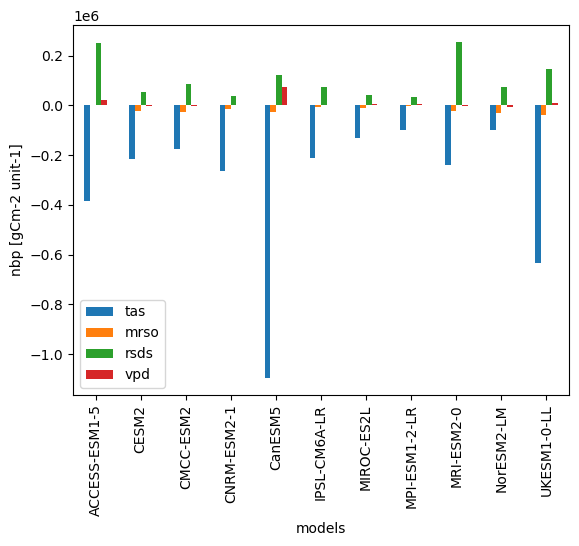

In [177]:
df_amz_ssp.plot.bar(stacked = False, ylabel = "nbp [gCm-2 unit-1]")

In [189]:
gamma_tas_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_tas]
gamma_mrso_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_mrso]
gamma_rsds_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_rsds]
gamma_vpd_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_vpd]

gamma_tas_amz = [a.rename("tas") for a in gamma_tas_amz]
gamma_mrso_amz = [a.rename("mrso") for a in gamma_mrso_amz]
gamma_rsds_amz = [a.rename("rsds") for a in gamma_rsds_amz]
gamma_vpd_amz = [a.rename("vpd") for a in gamma_vpd_amz]

# df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, models)))
gamma_tas_amz = xr.concat(gamma_tas_amz, dim = "models", coords='minimal', compat='override').to_dataframe(); gamma_tas_amz = gamma_tas_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(gamma_tas_amz.index, models)))
gamma_mrso_amz = xr.concat(gamma_mrso_amz, dim = "models").to_dataframe(); gamma_mrso_amz = gamma_mrso_amz.drop(columns = "region").rename(index=dict(zip(gamma_mrso_amz.index, models)))
gamma_rsds_amz = xr.concat(gamma_rsds_amz, dim = "models").to_dataframe(); gamma_rsds_amz = gamma_rsds_amz.drop(columns = "region").rename(index=dict(zip(gamma_rsds_amz.index, models)))
gamma_vpd_amz = xr.concat(gamma_vpd_amz, dim = "models", coords='minimal', compat='override').to_dataframe(); gamma_vpd_amz = gamma_vpd_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(gamma_vpd_amz.index, models)))

gamma_amz = pd.concat([gamma_tas_amz, gamma_mrso_amz, gamma_rsds_amz, gamma_vpd_amz], axis = 1)

In [190]:
gamma_nbp_tas_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_nbp_tas]
gamma_nbp_mrso_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_nbp_mrso]
gamma_nbp_rsds_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_nbp_rsds]
gamma_nbp_vpd_amz = [zonal_stat(a.astype("float64"), geodf).sel(region = 1) for a in gamma_nbp_vpd]

gamma_nbp_tas_amz = [a.rename("tas") for a in gamma_nbp_tas_amz]
gamma_nbp_mrso_amz = [a.rename("mrso") for a in gamma_nbp_mrso_amz]
gamma_nbp_rsds_amz = [a.rename("rsds") for a in gamma_nbp_rsds_amz]
gamma_nbp_vpd_amz = [a.rename("vpd") for a in gamma_nbp_vpd_amz]

# df_coef_ridge_ssp_pr = xr.concat(coef_ridge_ssp_pr_amz, dim = "models").to_dataframe(); df_coef_ridge_ssp_pr = df_coef_ridge_ssp_pr.drop(columns = "region").rename(index=dict(zip(df_coef_ridge_ssp_pr.index, models)))
gamma_nbp_tas_amz = xr.concat(gamma_nbp_tas_amz, dim = "models", coords='minimal', compat='override').to_dataframe(); gamma_nbp_tas_amz = gamma_nbp_tas_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(gamma_nbp_tas_amz.index, models)))
gamma_nbp_mrso_amz = xr.concat(gamma_nbp_mrso_amz, dim = "models").to_dataframe(); gamma_nbp_mrso_amz = gamma_nbp_mrso_amz.drop(columns = "region").rename(index=dict(zip(gamma_nbp_mrso_amz.index, models)))
gamma_nbp_rsds_amz = xr.concat(gamma_nbp_rsds_amz, dim = "models").to_dataframe(); gamma_nbp_rsds_amz = gamma_nbp_rsds_amz.drop(columns = "region").rename(index=dict(zip(gamma_nbp_rsds_amz.index, models)))
gamma_nbp_vpd_amz = xr.concat(gamma_nbp_vpd_amz, dim = "models", coords='minimal', compat='override').to_dataframe(); gamma_nbp_vpd_amz = gamma_nbp_vpd_amz.drop(columns = ["region", "height"]).rename(index=dict(zip(gamma_nbp_vpd_amz.index, models)))

gamma_nbp_amz = pd.concat([gamma_nbp_tas_amz, gamma_nbp_mrso_amz, gamma_nbp_rsds_amz, gamma_nbp_vpd_amz], axis = 1)

<AxesSubplot: xlabel='models'>

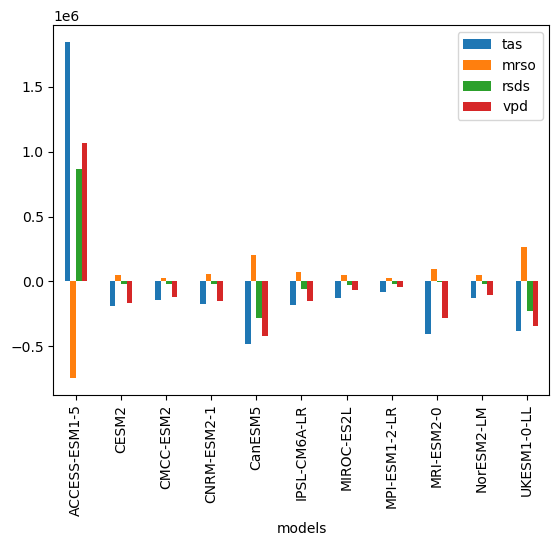

In [191]:
gamma_amz.plot.bar(stacked = False)

<AxesSubplot: xlabel='models'>

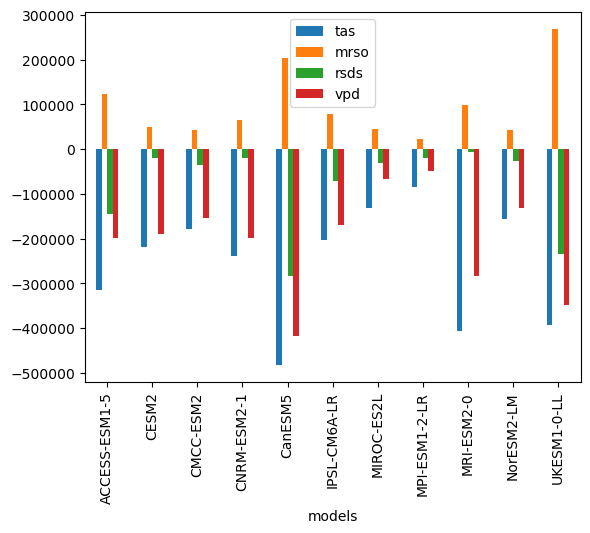

In [192]:
gamma_nbp_amz.plot.bar(stacked = False)